In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.
import os
from os import getcwd

# Import all the necessary files!
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers

In [2]:
path_inception = f"{getcwd()}/../inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

# Print the model summary
# pre_trained_model.summary()

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.97:
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.summary()

c:\users\enrico\onedrive\desktop\courses\hands-on-tensorflow\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [6]:
# Define our example directories and files
train_dir = './data/training'
validation_dir = './data/validation'

train_horses_dir = train_dir + '/horses'
train_humans_dir = train_dir + '/humans'
validation_horses_dir =  validation_dir + '/horses'
validation_humans_dir = validation_dir + '/humans'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [7]:
from random import shuffle
for directory in [train_horses_dir, train_humans_dir, validation_horses_dir, validation_humans_dir]:
    files = [os.path.abspath(os.path.join(directory,fle)) for fle in os.listdir(directory) if fle.endswith(".png")]
    shuffle(files)
    print(files)

['C:\\Users\\enrico\\OneDrive\\Desktop\\courses\\hands-on-tensorflow\\cnn\\binary_classification\\horses_vs_humans\\data\\training\\horses\\horse45-6.png', 'C:\\Users\\enrico\\OneDrive\\Desktop\\courses\\hands-on-tensorflow\\cnn\\binary_classification\\horses_vs_humans\\data\\training\\horses\\horse37-4.png', 'C:\\Users\\enrico\\OneDrive\\Desktop\\courses\\hands-on-tensorflow\\cnn\\binary_classification\\horses_vs_humans\\data\\training\\horses\\horse28-1.png', 'C:\\Users\\enrico\\OneDrive\\Desktop\\courses\\hands-on-tensorflow\\cnn\\binary_classification\\horses_vs_humans\\data\\training\\horses\\horse34-7.png', 'C:\\Users\\enrico\\OneDrive\\Desktop\\courses\\hands-on-tensorflow\\cnn\\binary_classification\\horses_vs_humans\\data\\training\\horses\\horse26-5.png', 'C:\\Users\\enrico\\OneDrive\\Desktop\\courses\\hands-on-tensorflow\\cnn\\binary_classification\\horses_vs_humans\\data\\training\\horses\\horse10-7.png', 'C:\\Users\\enrico\\OneDrive\\Desktop\\courses\\hands-on-tensorflow\\

In [8]:
from keras_preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)
)

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [9]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy

callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    epochs=3,
    verbose=1,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

c:\users\enrico\onedrive\desktop\courses\hands-on-tensorflow\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
52/52 [==============================] - 20s 337ms/step - loss: 0.1616 - accuracy: 0.9435 - val_loss: 0.0559 - val_accuracy: 0.9766

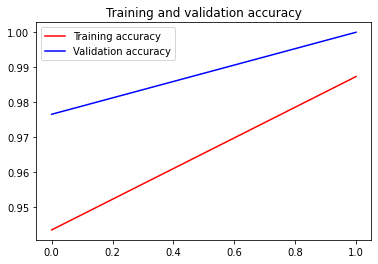

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()